В цій практичній роботі ми спробуємо реалізувати нейронну мережу з двох шарів (прихований і вихідний). Запропонований підхід стане заготовкою для реалізації наступних оптимізацій: MBGD, ADAM та регуляризації. 

Сьогодні ж вам пропонується додати до цього класу підтримку довільної кількості шарів та нейронів в них (наприклад, передавати їх параметром в конструктор, як це робиться в MLPClassifier за допомогою hidden_layer_sizes). Також потрібно передбачити можливість ранньої зупинки ітераційного процесу, якщо значення штрафної функції не покращуватиметься протягом певної кількості ітерацій. Наприклад, якщо протягом $k$ ітерацій штрафна функція за модулем не стане меншою, ніж на поточному кроці.

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

from matplotlib.colors import ListedColormap
%matplotlib inline
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder

import sklearn.linear_model

np.random.seed(1)

In [2]:
def plot_surface(cls, x_1, x_2, ax=None, threshold=0.5, contourf=False):
    xx1, xx2 = np.meshgrid(np.linspace(x_1.min(), x_1.max(), 100), 
                           np.linspace(x_2.min(), x_2.max(), 100))

    X_pred = np.c_[xx1.ravel(), xx2.ravel()]
    pred = cls.predict_proba(X_pred)[:, 0]
    Z = pred.reshape((100, 100))
    if ax is None:
        ax = plt.gca()
    ax.contour(xx1, xx2, Z, levels=[threshold], colors='black')
    ax.set_xlim((x_1.min(), x_1.max()))
    ax.set_ylim((x_2.min(), x_2.max()))

In [3]:
class SoftmaxNeuralNet:

  def __init__(self, layer_dims, normalize=True, learning_rate=0.01, num_iter=30000, precision=None):
    self.learning_rate = learning_rate
    self.num_iter = num_iter
    self.normalize = normalize
    self.layer_dims = layer_dims
    self.precision = precision

  def __normalize(self, X, mean=None, std=None):
    n = X.shape[0]

    if mean is None:
      mean = np.mean(X, axis=1).reshape((n, 1))

    if std is None:
      std = np.std(X, axis=1).reshape((n, 1))
      
    X_new = (X - mean) / std**2
    
    return X_new, mean, std

  def __sigmoid(self, Z):
    return 1 / (1 + np.exp(-Z))

  def __sigmoid_derivative(self, Z):
    s = self.__sigmoid(Z)
    return s*(1 - s)

  def __relu(self, Z):
    Z = np.array(Z, copy=True)
    Z[Z < 0] = 0.001
    return Z

  def __relu_derivative(self, Z):
    dZ = np.ones(Z.shape)
    dZ[Z <=0 ] = 0
    return dZ

  def __tanh(self, Z):
    return np.tanh(Z)

  def __tanh_derivative(self, Z):
    return 1 / np.power(np.cosh(Z), 2)

  def __softmax(self, Z):
    eZ = np.exp(Z - np.max(Z))
    return eZ / np.sum(eZ, axis=0, keepdims=True)

  def __initialize_parameters(self):
    layer_dims = self.layer_dims
    parameters = {}
    L = len(layer_dims)

    for l in range(1, L):
      parameters['W' + str(l)] = np.random.randn(layer_dims[l], layer_dims[l-1]) * 0.01
      print(parameters['W' + str(l)].shape)
      parameters['b' + str(l)] = np.zeros((layer_dims[l], 1))

    
    self.parameters = parameters

  def __forward_linear_activation(self, A_prev, W, b, activation):

    # linear forward
    Z = np.dot(W, A_prev) + b
    linear_cache = (A_prev, W, b)

    # activation forward
    if activation == 'sigmoid':
      A = self.__sigmoid(Z)
    
    if activation == 'relu':
      A = self.__relu(Z)
    
    if activation == 'softmax':
      A = self.__softmax(Z)

    if activation == 'tanh':
      A = self.__tanh(Z)
    
    activation_cache = Z

    cache = (linear_cache, activation_cache)

    return A, cache

  def __multilayer_forward(self, X):
    parameters = self.parameters
    caches = []
    A = X
    L = len(parameters) // 2

    for l in range(1, L):
      A_prev = A
      A, cache = self.__forward_linear_activation(
        A_prev, parameters["W"+str(l)], parameters["b"+str(l)], activation='tanh')
      caches.append(cache)

    AL, cache = self.__forward_linear_activation(
      A, parameters["W"+str(L)], parameters["b"+str(L)], activation='softmax')
    caches.append(cache)

    assert(AL.shape == (10, X.shape[1]))
    
    return AL, caches

  def __backward_linear_activation(self, dA, cache, activation):

    linear_cache, activation_cache = cache

    # activation backward
    Z = activation_cache
    A_prev, W, b = linear_cache
    
    if activation == 'sigmoid':
      dZ = dA * self.__sigmoid_derivative(Z)

    if activation == 'relu':
      dZ = dA * self.__relu_derivative(Z)
    
    if activation == 'tanh':
      dZ = dA * self.__tanh_derivative(Z)

    # linear backward
    A_prev, W, b = linear_cache
    m = A_prev.shape[1]
    dW = 1 / m * np.dot(dZ, A_prev.T)
    db = 1 / m * np.sum(dZ, axis=1, keepdims=True)
    dA_prev = np.dot(W.T, dZ)

    return dA_prev, dW, db

  def __multilayer_backward(self, X, Y, caches):
    grads = {}
    AL = X
    L = len(caches)
    m = AL.shape[1]
    Y = Y.reshape(AL.shape)
   
    
    linear_cache, activation_cache = caches[L-1]
    A_prev, W, b = linear_cache
    
    dZ = AL - Y
    m = AL.shape[1]
    grads["dW" + str(L)] = 1 / m * np.dot(dZ, A_prev.T)
    grads["db" + str(L)] = 1 / m * np.sum(dZ, axis=1, keepdims=True)
    grads["dA" + str(L-1)] = np.dot(W.T, dZ)
    
    for l in reversed(range(L-1)):
      current_cache = caches[l]
      dA_prev_temp, dW_temp, db_temp = \
        self.__backward_linear_activation(grads["dA" + str(l + 1)], current_cache, activation='tanh')
      grads["dA" + str(l)] = dA_prev_temp
      grads["dW" + str(l + 1)] = dW_temp
      grads["db" + str(l + 1)] = db_temp

    return grads

  def compute_cost(self, A, Y):
    J = -np.mean(Y.T * np.log(A.T+ 1e-8))
    return J

  def cross_entropy(self, A, Y):
    return - np.sum(Y * np.log(A), axis=1)

  def __update_parameters(self, grads):
    parameters = self.parameters
    learning_rate = self.learning_rate
    L = len(parameters) // 2

    for l in range(L):
      parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - learning_rate * grads["dW" + str(l+1)]
      parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - learning_rate * grads["db" + str(l+1)]

    self.parameters = parameters

  def fit(self, X_vert, Y_vert, print_cost=True):

    X, Y = X_vert.T, Y_vert.T

    if self.normalize:
      X, self.__mean, self.__std = self.__normalize(X)

    costs = []

    self.__initialize_parameters()

    for i in range(0, self.num_iter):

      AL, caches = self.__multilayer_forward(X)

      cost = self.compute_cost(AL, Y)

      grads = self.__multilayer_backward(AL, Y, caches)

      self.__update_parameters(grads)

      if print_cost and i % 10 == 0:
        print("Cost after iteration %i: %f" % (i, cost))
      if print_cost and i % 10 == 0:
        costs.append(cost)

      if len(costs) > 1 and self.precision != None and np.abs(costs[-2] - costs[-1]) < self.precision:
        print('Stopping gradient descent ...')
        break

    if print_cost:
      plt.plot(costs)
      plt.ylabel("Cost")
      plt.xlabel("Iteration, *100")
      plt.show()

  def predict_proba(self, X_vert):
    X = X_vert.T
    if self.normalize:
      X, _, _ = self.__normalize(X, self.__mean, self.__std)

    probs = self.__multilayer_forward(X)[0]

    return probs.T

  def predict(self, X_vert):
    positive_probs = self.predict_proba(X_vert)
    return np.argmax(positive_probs, axis = 1)

In [4]:
df = pd.read_csv("data/large/train.csv")
df.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
X, Y = df.drop('label', axis=1), df['label']
print('Training set: X={}, y={}'.format(X.shape, Y.shape))

Training set: X=(42000, 784), y=(42000,)


In [6]:
#X, _, Y , _= train_test_split(X, Y.values.reshape((Y.shape[0], 1)), test_size = 0.9, random_state=10)
#print(X.shape, Y.shape)

In [7]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y.values.reshape((Y.shape[0], 1)), test_size = 0.2, random_state=10)

In [8]:
X_train = X_train / 255
X_test = X_test / 255

In [9]:
encoder = OneHotEncoder()

In [10]:
Y_train.shape

(33600, 1)

In [11]:
Y_train_e = encoder.fit_transform(Y_train).toarray()
Y_train.shape

(33600, 1)

In [12]:
cls = SoftmaxNeuralNet(layer_dims = [784, 60, 10], normalize = False, learning_rate = 0.1, num_iter = 450)

(60, 784)
(10, 60)
Cost after iteration 0: 0.230175
Cost after iteration 10: 0.228661
Cost after iteration 20: 0.225947
Cost after iteration 30: 0.220187
Cost after iteration 40: 0.208723
Cost after iteration 50: 0.190049
Cost after iteration 60: 0.167515
Cost after iteration 70: 0.146406
Cost after iteration 80: 0.128747
Cost after iteration 90: 0.114523
Cost after iteration 100: 0.103120
Cost after iteration 110: 0.093920
Cost after iteration 120: 0.086431
Cost after iteration 130: 0.080265
Cost after iteration 140: 0.075123
Cost after iteration 150: 0.070782
Cost after iteration 160: 0.067074
Cost after iteration 170: 0.063871
Cost after iteration 180: 0.061076
Cost after iteration 190: 0.058615
Cost after iteration 200: 0.056430
Cost after iteration 210: 0.054476
Cost after iteration 220: 0.052719
Cost after iteration 230: 0.051130
Cost after iteration 240: 0.049688
Cost after iteration 250: 0.048373
Cost after iteration 260: 0.047170
Cost after iteration 270: 0.046067
Cost after i

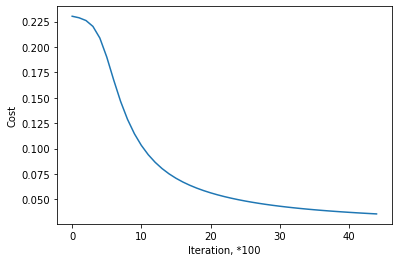

In [13]:
cls.fit(X_train, Y_train_e)

In [14]:
print(cls.parameters)

{'W1': array([[ 1.62434536e-02, -6.11756414e-03, -5.28171752e-03, ...,
        -1.10657307e-02, -3.59224096e-03,  5.05381903e-03],
       [ 1.21794090e-02, -1.94068096e-02, -8.06178212e-03, ...,
         2.07229946e-03, -1.43403073e-02,  6.26906306e-03],
       [ 2.99825202e-03, -1.85664142e-02, -2.15104316e-02, ...,
        -1.95419182e-02,  1.86223746e-03, -3.82994307e-05],
       ...,
       [ 7.85812220e-03,  6.57456795e-03,  6.37326204e-03, ...,
         9.56189284e-03,  1.18337456e-02,  2.18726377e-02],
       [-1.07996566e-02, -1.49725917e-03,  1.39717091e-02, ...,
        -7.61156529e-03,  1.28740460e-02,  6.56379966e-03],
       [ 9.54058572e-03,  1.03352868e-03,  7.60558905e-03, ...,
         1.26743192e-03,  1.98366136e-03,  1.17245461e-02]]), 'b1': array([[ 0.00842719],
       [-0.04470297],
       [ 0.0734461 ],
       [ 0.03874039],
       [ 0.06430759],
       [-0.07483571],
       [-0.02598592],
       [ 0.01980663],
       [-0.05008748],
       [-0.01554188],
       [-

In [15]:
Y_prob = cls.predict_proba(X_train)
Y_prob

array([[4.98560280e-05, 1.24157457e-04, 2.32092882e-05, ...,
        1.09342873e-03, 2.56809365e-02, 8.71137068e-02],
       [3.47473619e-04, 3.44092151e-03, 1.32941094e-04, ...,
        7.62678378e-01, 7.41221862e-03, 2.20159892e-01],
       [1.06490346e-04, 5.07992952e-05, 1.27572324e-04, ...,
        9.67934781e-01, 3.74480558e-04, 3.07466056e-02],
       ...,
       [2.65344542e-03, 4.41191257e-03, 1.70756326e-02, ...,
        6.51544469e-05, 3.20271302e-01, 1.37380840e-03],
       [2.13515549e-04, 1.21317269e-05, 5.13402565e-03, ...,
        1.20504364e-06, 2.28422285e-03, 1.80441454e-04],
       [9.86261530e-01, 2.02985124e-07, 4.07001759e-04, ...,
        7.71171000e-05, 2.33094589e-04, 3.43090431e-05]])

In [16]:
Y_train_hat = cls.predict(X_train)
Y_test_hat = cls.predict(X_test)

In [17]:
accuracy_score(Y_train, Y_train_hat)

0.903720238095238

In [18]:
accuracy_score(Y_test, Y_test_hat)

0.9005952380952381